# Paper-Ready Figures

Generates publication-quality figures from evaluation results (`outputs/stepB_eval.tsv`).

**Main figures** (saved to `outputs/paper_figures/main/`):
1. Mean NLL per corruption regime (2x2 grid)
2. Context curves per corruption regime (2x2 grid)
3. Robustness delta vs baseline

**Appendix figures** (saved to `outputs/paper_figures/appendix/`):
- Training curves and alignment diagnostics (optional)

In [19]:
import sys, os

_d = os.getcwd()
while _d != os.path.dirname(_d):
    if os.path.isfile(os.path.join(_d, 'config.py')):
        break
    _d = os.path.dirname(_d)
REPO_ROOT = _d

os.chdir(REPO_ROOT)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print(f'Working directory: {os.getcwd()}')

Working directory: /Users/louishayot/MVA/VdS_Submission_Final


In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import warnings

# ---------- Matplotlib rcParams for publication ----------
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'legend.frameon': False,
    'lines.linewidth': 1.8,
    'lines.markersize': 5,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 150,
    'savefig.dpi': 300,
})

# ---------- Paths ----------
OUTPUT_DIR = 'outputs'
FIG_ROOT = os.path.join(OUTPUT_DIR, 'paper_figures')
MAIN_DIR = os.path.join(FIG_ROOT, 'main')
APPENDIX_DIR = os.path.join(FIG_ROOT, 'appendix')
os.makedirs(MAIN_DIR, exist_ok=True)
os.makedirs(APPENDIX_DIR, exist_ok=True)

MAKE_APPENDIX = True

print(f'Main figures -> {MAIN_DIR}')
print(f'Appendix figures -> {APPENDIX_DIR}')

Main figures -> outputs/paper_figures/main
Appendix figures -> outputs/paper_figures/appendix


In [21]:
# ============================================================
# Load + tidy
# ============================================================
TSV_PATH = os.path.join(OUTPUT_DIR, 'stepB_eval.tsv')
df = pd.read_csv(TSV_PATH, sep='\t')

# Parse method_id from run_name (everything before _seed)
df['method_id'] = df['run_name'].str.replace(r'_seed\d+$', '', regex=True)

# Rename columns for consistency
df = df.rename(columns={'eval_corruption_mode': 'corruption'})

# Categorical ordering
METHOD_ORDER = ['baseline', 'aggressive_align_rT', 'safe_align_rC']
CORRUPTION_ORDER = ['clean', 'noisy_low', 'noisy_high', 'permuted']
df['method_id'] = pd.Categorical(df['method_id'], categories=METHOD_ORDER, ordered=True)
df['corruption'] = pd.Categorical(df['corruption'], categories=CORRUPTION_ORDER, ordered=True)

# Label maps
METHOD_LABELS = {
    'baseline': 'INP (baseline)',
    'aggressive_align_rT': r'INP-Align (align to $r_T$)',
    'safe_align_rC': r'INP-Align (align to $r_C$)',
}
CORRUPTION_LABELS = {
    'clean': 'Clean knowledge',
    'noisy_low': 'Noisy knowledge (low)',
    'noisy_high': 'Noisy knowledge (high)',
    'permuted': 'Permuted knowledge',
}

# Color + marker maps
METHOD_COLORS = {
    'baseline': '#1f77b4',
    'aggressive_align_rT': '#d62728',
    'safe_align_rC': '#2ca02c',
}
METHOD_MARKERS = {
    'baseline': 'o',
    'aggressive_align_rT': 's',
    'safe_align_rC': '^',
}

# Build long-form df for context curves
CONTEXT_SIZES = [0, 3, 5, 10]
long_rows = []
for _, row in df.iterrows():
    for C in CONTEXT_SIZES:
        long_rows.append({
            'method_id': row['method_id'],
            'seed': row['seed'],
            'corruption': row['corruption'],
            'C': C,
            'nll': row[f'eval_nll_{C}'],
        })
df_long = pd.DataFrame(long_rows)
df_long['method_id'] = pd.Categorical(df_long['method_id'], categories=METHOD_ORDER, ordered=True)
df_long['corruption'] = pd.Categorical(df_long['corruption'], categories=CORRUPTION_ORDER, ordered=True)

n_seeds = df['seed'].nunique()
if n_seeds < 3:
    warnings.warn(f'Only {n_seeds} seed(s) found — std shading will be suppressed.')

print(f'Loaded {len(df)} rows, {n_seeds} seed(s)')
print(df.head())

Loaded 36 rows, 3 seed(s)
                    run_name                            run_dir  seed  \
0  aggressive_align_rT_seed0  outputs/aggressive_align_rT_seed0     0   
1  aggressive_align_rT_seed0  outputs/aggressive_align_rT_seed0     0   
2  aggressive_align_rT_seed0  outputs/aggressive_align_rT_seed0     0   
3  aggressive_align_rT_seed0  outputs/aggressive_align_rT_seed0     0   
4  aggressive_align_rT_seed1  outputs/aggressive_align_rT_seed1     1   

   corruption  sigma_rel  eval_nll_0  eval_nll_3  eval_nll_5  eval_nll_10  \
0       clean        0.0  117.980218   37.440580   14.730977    -1.968786   
1   noisy_low        0.1  200.588844   82.207563   49.114308     9.693605   
2  noisy_high        0.3  528.685467  269.028362  183.359228    91.612241   
3    permuted        0.0  676.416428  304.212799  197.850965    96.194700   
4       clean        0.0  108.678878   25.504420   10.173096    -2.518293   

   mean_eval_nll            method_id  
0      42.045747  aggressive_ali

In [22]:
# ============================================================
# Sanity checks
# ============================================================
required_cols = {'run_name', 'seed', 'corruption', 'sigma_rel',
                 'eval_nll_0', 'eval_nll_3', 'eval_nll_5', 'eval_nll_10',
                 'mean_eval_nll', 'method_id'}
missing = required_cols - set(df.columns)
assert not missing, f'Missing columns: {missing}'

print('Counts per method / corruption / seed:')
print(df.groupby(['method_id', 'corruption']).size().unstack(fill_value=0))
print(f'\nSeeds present: {sorted(df["seed"].unique())}')

Counts per method / corruption / seed:
corruption           clean  noisy_low  noisy_high  permuted
method_id                                                  
baseline                 3          3           3         3
aggressive_align_rT      3          3           3         3
safe_align_rC            3          3           3         3

Seeds present: [0, 1, 2]


/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/1018950385.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['method_id', 'corruption']).size().unstack(fill_value=0))


/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/3979650493.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = sub.groupby('method_id')['mean_eval_nll']
/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/3979650493.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = sub.groupby('method_id')['mean_eval_nll']
/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/3979650493.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tr

Saved outputs/paper_figures/main/fig1_mean_nll_grid.pdf


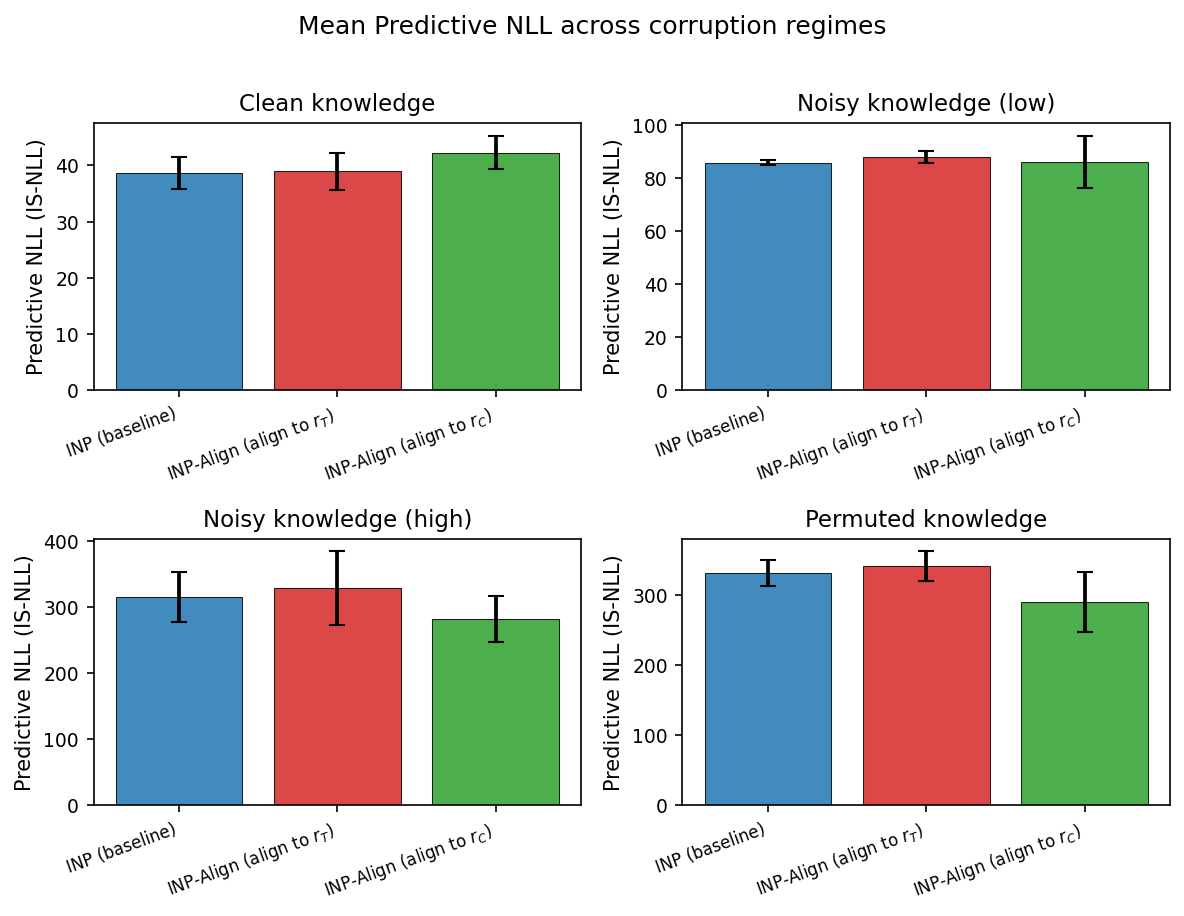

In [23]:
# ============================================================
# FIG 1: Mean NLL per corruption (2x2 grid, bar chart)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=False)
axes = axes.ravel()

for ax_idx, corr in enumerate(CORRUPTION_ORDER):
    ax = axes[ax_idx]
    sub = df[df['corruption'] == corr]
    grp = sub.groupby('method_id')['mean_eval_nll']
    means = grp.mean().reindex(METHOD_ORDER)
    stds = grp.std().reindex(METHOD_ORDER)

    x_pos = np.arange(len(METHOD_ORDER))
    colors = [METHOD_COLORS[m] for m in METHOD_ORDER]
    labels = [METHOD_LABELS[m] for m in METHOD_ORDER]

    if n_seeds >= 2:
        ax.bar(x_pos, means.values, yerr=stds.values, capsize=4,
               color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)
    else:
        ax.bar(x_pos, means.values, color=colors,
               edgecolor='black', linewidth=0.5, alpha=0.85)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=20, ha='right', fontsize=8)
    ax.set_title(CORRUPTION_LABELS[corr])
    ax.set_ylabel('Predictive NLL (IS-NLL)')

fig.suptitle('Mean Predictive NLL across corruption regimes', fontsize=12, y=1.01)
fig.tight_layout()
fig1_path = os.path.join(MAIN_DIR, 'fig1_mean_nll_grid.pdf')
fig.savefig(fig1_path, bbox_inches='tight', format='pdf')
print(f'Saved {fig1_path}')
plt.show()

Saved outputs/paper_figures/main/fig2_context_curves.pdf


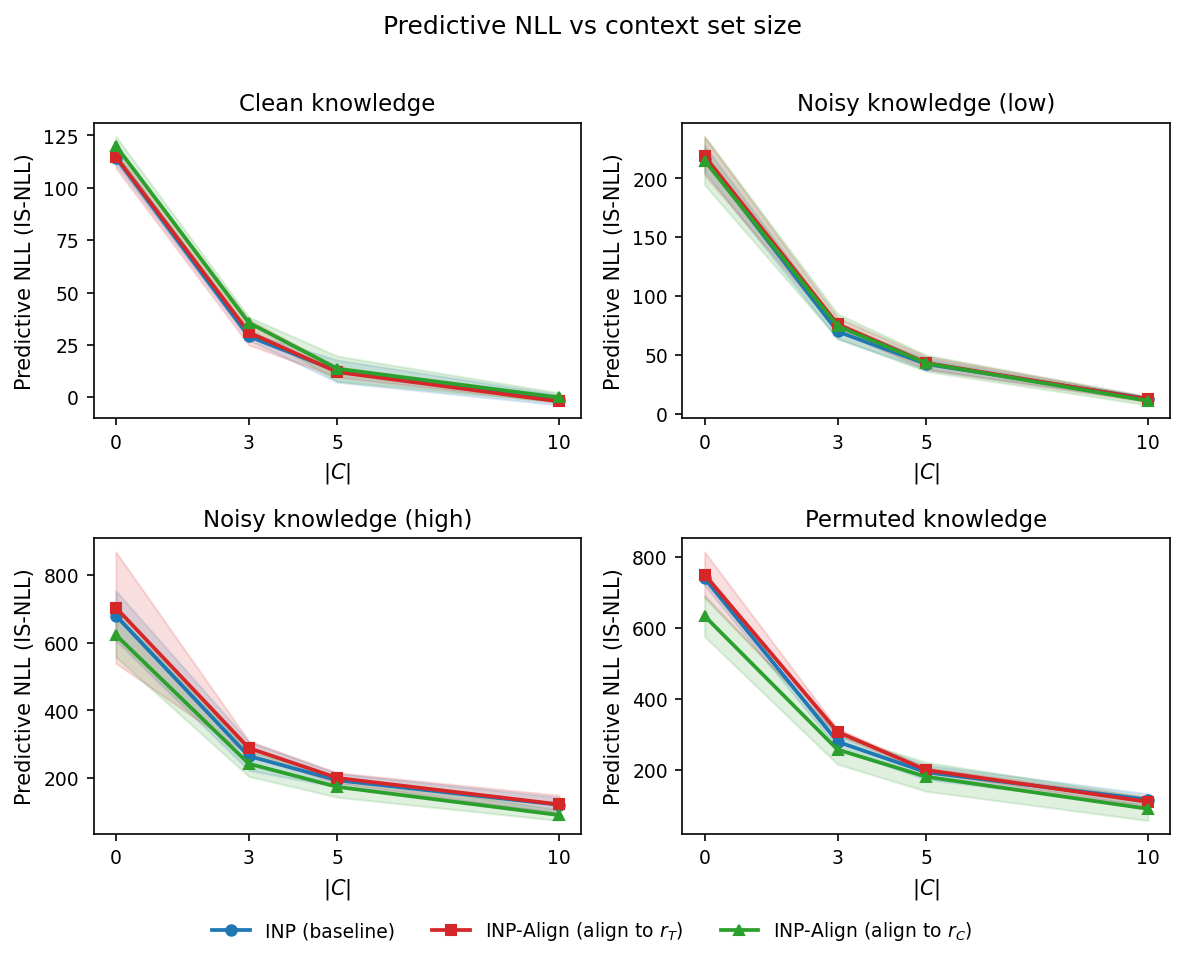

In [24]:
# ============================================================
# FIG 2: Context curves (2x2 grid, line plot)
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=False)
axes = axes.ravel()

for ax_idx, corr in enumerate(CORRUPTION_ORDER):
    ax = axes[ax_idx]
    sub = df_long[df_long['corruption'] == corr]

    for method in METHOD_ORDER:
        msub = sub[sub['method_id'] == method]
        grp = msub.groupby('C')['nll']
        m = grp.mean()
        s = grp.std()

        ax.plot(m.index, m.values, marker=METHOD_MARKERS[method],
                color=METHOD_COLORS[method], label=METHOD_LABELS[method])
        if n_seeds >= 2:
            ax.fill_between(m.index, (m - s).values, (m + s).values,
                            color=METHOD_COLORS[method], alpha=0.15)

    ax.set_xlabel('$|C|$')
    ax.set_ylabel('Predictive NLL (IS-NLL)')
    ax.set_title(CORRUPTION_LABELS[corr])
    ax.set_xticks(CONTEXT_SIZES)

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.04))

fig.suptitle('Predictive NLL vs context set size', fontsize=12, y=1.01)
fig.tight_layout()
fig2_path = os.path.join(MAIN_DIR, 'fig2_context_curves.pdf')
fig.savefig(fig2_path, bbox_inches='tight', format='pdf')
print(f'Saved {fig2_path}')
plt.show()

/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/1720313677.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = msub.groupby('corruption')['delta_nll']
/var/folders/n5/zkvwzmk55zld2mbmh5y4d47c0000gn/T/ipykernel_31982/1720313677.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = msub.groupby('corruption')['delta_nll']


Saved outputs/paper_figures/main/fig3_delta_vs_baseline.pdf


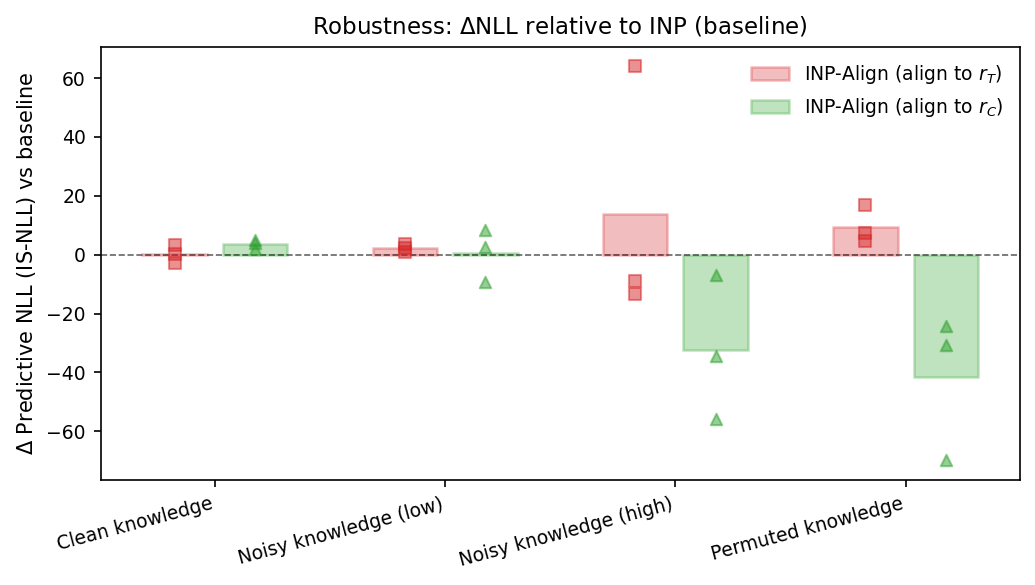

In [25]:
# ============================================================
# FIG 3: Robustness delta vs baseline
# ============================================================
# Seed-matched subtraction: delta(method, seed, corr) =
#   mean_eval_nll(method, seed, corr) - mean_eval_nll(baseline, seed, corr)

baseline_df = df[df['method_id'] == 'baseline'][['seed', 'corruption', 'mean_eval_nll']]
baseline_df = baseline_df.rename(columns={'mean_eval_nll': 'baseline_nll'})

align_methods = [m for m in METHOD_ORDER if m != 'baseline']
delta_rows = []
for method in align_methods:
    msub = df[df['method_id'] == method][['seed', 'corruption', 'mean_eval_nll']]
    merged = msub.merge(baseline_df, on=['seed', 'corruption'])
    merged['delta_nll'] = merged['mean_eval_nll'] - merged['baseline_nll']
    merged['method_id'] = method
    delta_rows.append(merged)

df_delta = pd.concat(delta_rows, ignore_index=True)
df_delta['corruption'] = pd.Categorical(df_delta['corruption'],
                                        categories=CORRUPTION_ORDER, ordered=True)

fig, ax = plt.subplots(figsize=(7, 4))

x_positions = np.arange(len(CORRUPTION_ORDER))
width = 0.35

for i, method in enumerate(align_methods):
    msub = df_delta[df_delta['method_id'] == method]
    grp = msub.groupby('corruption')['delta_nll']
    m = grp.mean().reindex(CORRUPTION_ORDER)
    offset = -width/2 + i * width

    # Individual seed points
    for seed_val in sorted(msub['seed'].unique()):
        ssub = msub[msub['seed'] == seed_val]
        vals = ssub.set_index('corruption')['delta_nll'].reindex(CORRUPTION_ORDER)
        ax.scatter(x_positions + offset, vals.values,
                   color=METHOD_COLORS[method], marker=METHOD_MARKERS[method],
                   s=30, alpha=0.5, zorder=3)

    # Mean bar
    ax.bar(x_positions + offset, m.values, width=width * 0.8,
           color=METHOD_COLORS[method], alpha=0.3, edgecolor=METHOD_COLORS[method],
           linewidth=1.2, label=METHOD_LABELS[method])

ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.6)
ax.set_xticks(x_positions)
ax.set_xticklabels([CORRUPTION_LABELS[c] for c in CORRUPTION_ORDER],
                    rotation=15, ha='right', fontsize=9)
ax.set_ylabel(r'$\Delta$ Predictive NLL (IS-NLL) vs baseline')
ax.set_title(r'Robustness: $\Delta$NLL relative to INP (baseline)')
ax.legend()

fig.tight_layout()
fig3_path = os.path.join(MAIN_DIR, 'fig3_delta_vs_baseline.pdf')
fig.savefig(fig3_path, bbox_inches='tight', format='pdf')
print(f'Saved {fig3_path}')
plt.show()

Saved outputs/paper_figures/appendix/figA1_training_nll.pdf


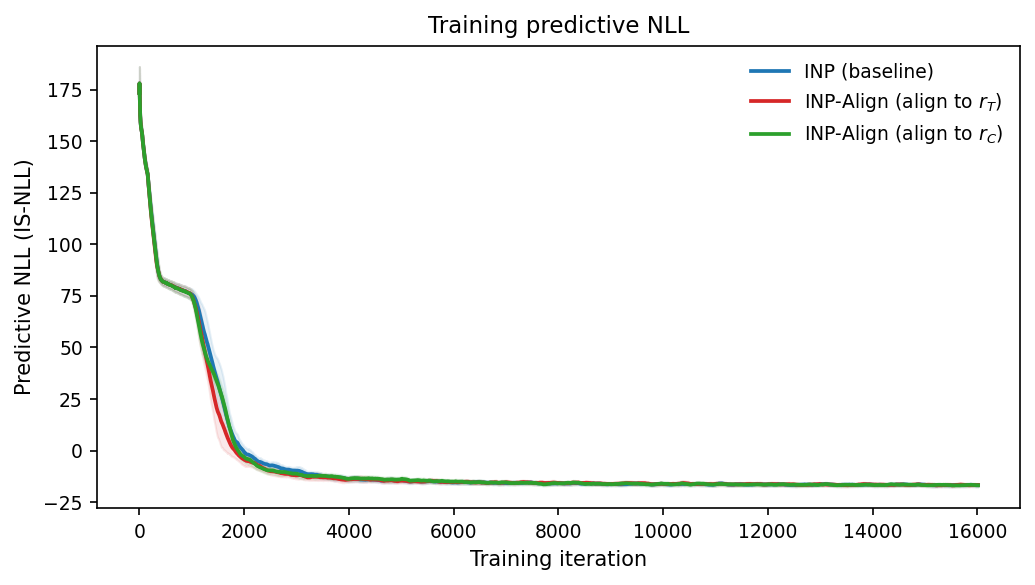

Saved outputs/paper_figures/appendix/figA1_training_nll_zoom.pdf


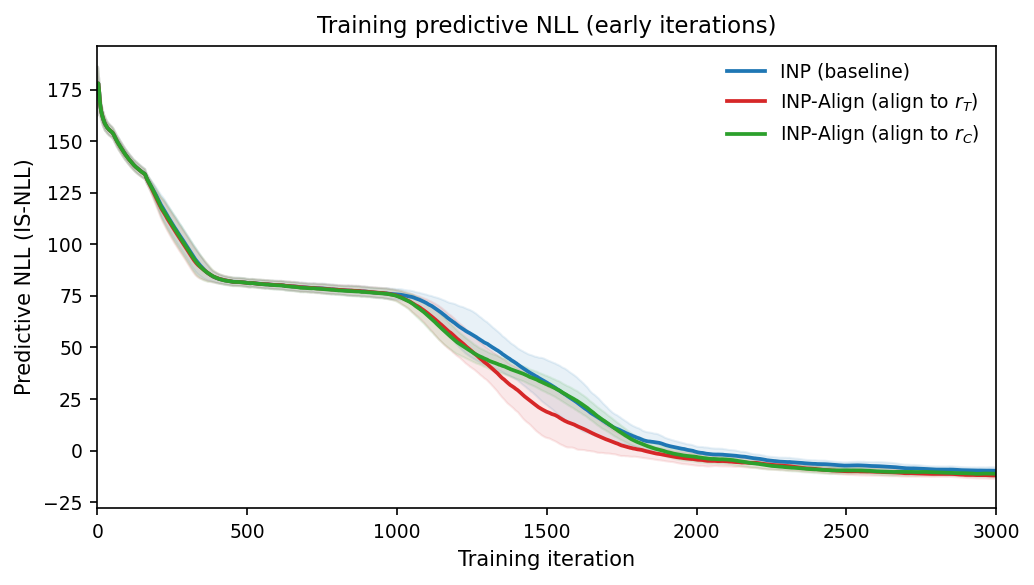


Alignment diagnostic rows found:
  aggressive_align_rT seed=0: 16016 rows
  aggressive_align_rT seed=1: 16016 rows
  aggressive_align_rT seed=2: 16016 rows
  safe_align_rC seed=0: 16016 rows
  safe_align_rC seed=1: 16016 rows
  safe_align_rC seed=2: 16016 rows

Aggregated alignment summary (last 50 steps, per run):
          method_id  seed  train_alignment_loss  train_retrieval_acc  train_mean_cosine
aggressive_align_rT     0              3.197278             0.106687           0.177473
aggressive_align_rT     1              3.144985             0.170375           0.213922
aggressive_align_rT     2              3.043531             0.139875           0.255407
      safe_align_rC     0              4.055227             0.024750           0.024097
      safe_align_rC     1              4.078088             0.024438           0.017425
      safe_align_rC     2              4.026211             0.038563           0.048909

Mean +/- std across seeds:
                    seed      train_al

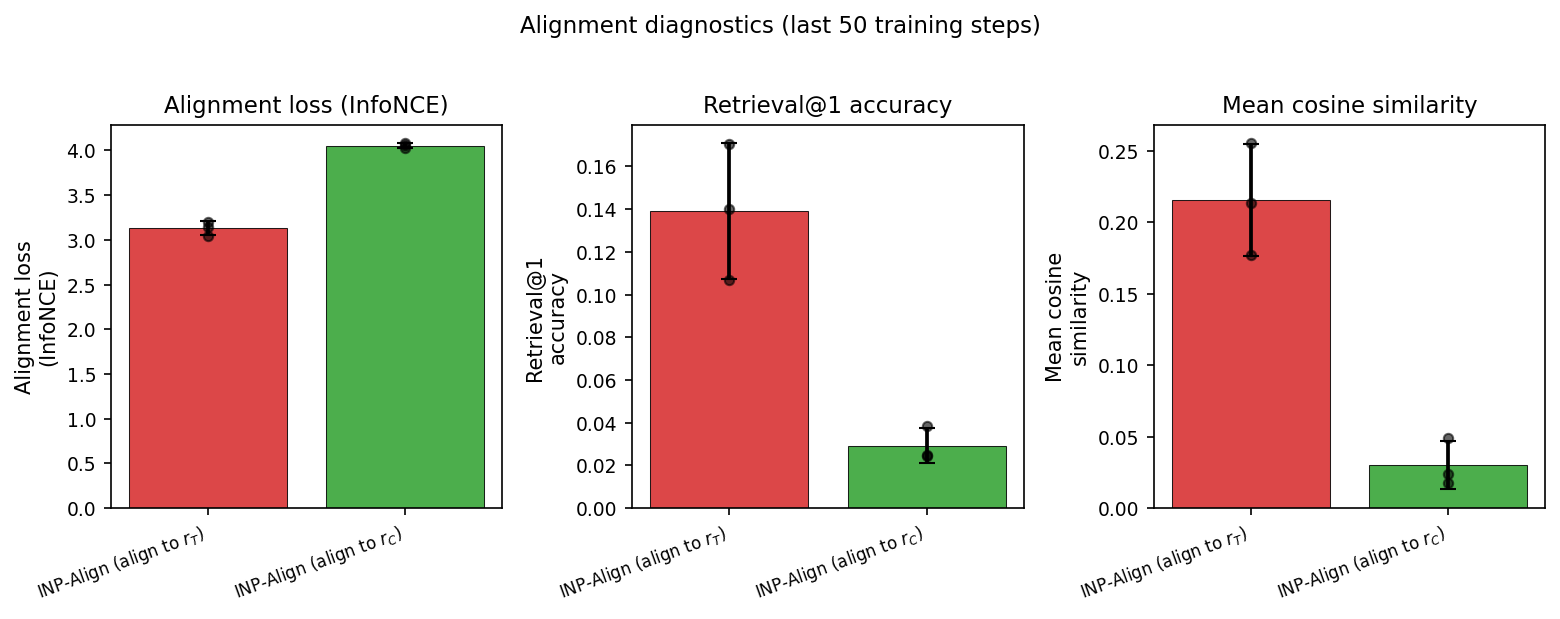

In [26]:
# ============================================================
# APPENDIX: Training curves + alignment diagnostics
# ============================================================
if not MAKE_APPENDIX:
    print('Skipping appendix figures (MAKE_APPENDIX=False)')
else:
    # Discover run dirs with metrics.jsonl
    run_dirs = sorted([
        d for d in os.listdir(OUTPUT_DIR)
        if os.path.isfile(os.path.join(OUTPUT_DIR, d, 'metrics.jsonl'))
    ])

    def load_metrics(run_name):
        path = os.path.join(OUTPUT_DIR, run_name, 'metrics.jsonl')
        records = []
        with open(path) as f:
            for line in f:
                records.append(json.loads(line))
        return pd.DataFrame(records)

    # Collect per method/seed: separate train_nll rows vs alignment rows
    # (they are logged on SEPARATE JSONL lines)
    all_train = {}
    all_align = {}
    for rn in run_dirs:
        method = rn.rsplit('_seed', 1)[0]
        seed = int(rn.rsplit('_seed', 1)[1])
        mdf = load_metrics(rn)

        # Training NLL rows
        train_rows = mdf[mdf['train_predictive_nll'].notna()].copy()
        if len(train_rows) > 0:
            train_rows = train_rows.reset_index(drop=True)
            train_rows['step'] = train_rows.index
            all_train[(method, seed)] = train_rows

        # Alignment diagnostic rows (separate lines)
        align_keys = ['train_alignment_loss', 'train_retrieval_acc', 'train_mean_cosine']
        present_keys = [k for k in align_keys if k in mdf.columns]
        if present_keys:
            align_rows = mdf[mdf[present_keys[0]].notna()].copy()
            if len(align_rows) > 0:
                for k in align_keys:
                    if k in align_rows.columns:
                        align_rows[k] = pd.to_numeric(align_rows[k], errors='coerce')
                align_rows = align_rows.reset_index(drop=True)
                align_rows['step'] = align_rows.index
                all_align[(method, seed)] = align_rows

    # Helper: build smoothed curves per method from a dict of (method,seed)->df
    def _build_method_curves(data_dict, col, method_list):
        """Returns {method: (steps, smoothed_mean, smoothed_std_or_None)}."""
        result = {}
        for method in method_list:
            curves = [tdf[col].values for (m, s), tdf in data_dict.items() if m == method]
            if not curves:
                continue
            min_len = min(len(c) for c in curves)
            arr = np.array([c[:min_len] for c in curves])
            mean_curve = arr.mean(axis=0)
            window = max(1, min_len // 100)
            smoothed = pd.Series(mean_curve).rolling(window, min_periods=1).mean().values
            steps = np.arange(min_len)
            std_sm = None
            if arr.shape[0] >= 2:
                std_curve = arr.std(axis=0)
                std_sm = pd.Series(std_curve).rolling(window, min_periods=1).mean().values
            result[method] = (steps, smoothed, std_sm)
        return result

    # ----- Fig A1: Training NLL curves (full) -----
    train_curves = _build_method_curves(all_train, 'train_predictive_nll', METHOD_ORDER)

    fig, ax = plt.subplots(figsize=(7, 4))
    for method in METHOD_ORDER:
        if method not in train_curves:
            continue
        steps, smoothed, std_sm = train_curves[method]
        ax.plot(steps, smoothed, color=METHOD_COLORS[method], label=METHOD_LABELS[method])
        if std_sm is not None:
            ax.fill_between(steps, smoothed - std_sm, smoothed + std_sm,
                            color=METHOD_COLORS[method], alpha=0.1)
    ax.set_xlabel('Training iteration')
    ax.set_ylabel('Predictive NLL (IS-NLL)')
    ax.set_title('Training predictive NLL')
    ax.legend()
    fig.tight_layout()
    figa1_path = os.path.join(APPENDIX_DIR, 'figA1_training_nll.pdf')
    fig.savefig(figa1_path, bbox_inches='tight', format='pdf')
    print(f'Saved {figa1_path}')
    plt.show()

    # ----- Fig A1 zoom: early training region -----
    fig, ax = plt.subplots(figsize=(7, 4))
    for method in METHOD_ORDER:
        if method not in train_curves:
            continue
        steps, smoothed, std_sm = train_curves[method]
        ax.plot(steps, smoothed, color=METHOD_COLORS[method], label=METHOD_LABELS[method])
        if std_sm is not None:
            ax.fill_between(steps, smoothed - std_sm, smoothed + std_sm,
                            color=METHOD_COLORS[method], alpha=0.1)
    ax.set_xlim(0, 3000)
    ax.set_xlabel('Training iteration')
    ax.set_ylabel('Predictive NLL (IS-NLL)')
    ax.set_title('Training predictive NLL (early iterations)')
    ax.legend()
    fig.tight_layout()
    figa1_zoom_path = os.path.join(APPENDIX_DIR, 'figA1_training_nll_zoom.pdf')
    fig.savefig(figa1_zoom_path, bbox_inches='tight', format='pdf')
    print(f'Saved {figa1_zoom_path}')
    plt.show()

    # ----- Fig A2: Alignment diagnostics (bar chart, last_k aggregation) -----
    align_keys = ['train_alignment_loss', 'train_retrieval_acc', 'train_mean_cosine']
    align_methods_only = [m for m in METHOD_ORDER if m != 'baseline']
    LAST_K = 50

    # Filter to alignment methods only
    align_data = {k: v for k, v in all_align.items() if k[0] in align_methods_only}

    # Debug: print counts
    print(f'\nAlignment diagnostic rows found:')
    for (m, s), adf in sorted(align_data.items()):
        print(f'  {m} seed={s}: {len(adf)} rows')

    figa2_path = os.path.join(APPENDIX_DIR, 'figA2_alignment_diagnostics.pdf')

    if len(align_data) == 0:
        print('[WARN] No alignment diagnostics available — skipping figA2.')
        if os.path.isfile(figa2_path):
            os.remove(figa2_path)
    else:
        # For each run: take last_k rows, compute mean per metric
        # Then aggregate across seeds per method_id
        summary_rows = []
        for (method, seed), adf in align_data.items():
            tail = adf.tail(LAST_K)
            row = {'method_id': method, 'seed': seed}
            for k in align_keys:
                if k in tail.columns:
                    row[k] = tail[k].mean()
                else:
                    row[k] = np.nan
            summary_rows.append(row)

        df_align_summary = pd.DataFrame(summary_rows)
        print(f'\nAggregated alignment summary (last {LAST_K} steps, per run):')
        print(df_align_summary.to_string(index=False))

        # Aggregate across seeds
        agg = df_align_summary.groupby('method_id').agg(['mean', 'std']).reindex(align_methods_only)
        print(f'\nMean +/- std across seeds:')
        print(agg.to_string())

        # Check we have actual data to plot
        has_data = any(
            not agg[(k, 'mean')].isna().all()
            for k in align_keys if k in agg.columns.get_level_values(0)
        )

        if not has_data:
            print('[WARN] All alignment metrics are NaN — skipping figA2.')
            if os.path.isfile(figa2_path):
                os.remove(figa2_path)
        else:
            align_plot_labels = {
                'train_alignment_loss': 'Alignment loss\n(InfoNCE)',
                'train_retrieval_acc': 'Retrieval@1\naccuracy',
                'train_mean_cosine': 'Mean cosine\nsimilarity',
            }
            present_keys = [k for k in align_keys
                            if k in agg.columns.get_level_values(0)
                            and not agg[(k, 'mean')].isna().all()]
            n_panels = len(present_keys)

            fig, axes_a2 = plt.subplots(1, n_panels, figsize=(3.5 * n_panels, 4))
            if n_panels == 1:
                axes_a2 = [axes_a2]

            for panel_idx, key in enumerate(present_keys):
                ax = axes_a2[panel_idx]
                x_pos = np.arange(len(align_methods_only))
                means = [agg.loc[m, (key, 'mean')] if m in agg.index else np.nan
                         for m in align_methods_only]
                stds = [agg.loc[m, (key, 'std')] if m in agg.index else np.nan
                        for m in align_methods_only]
                colors = [METHOD_COLORS[m] for m in align_methods_only]
                labels = [METHOD_LABELS[m] for m in align_methods_only]

                if n_seeds >= 2:
                    ax.bar(x_pos, means, yerr=stds, capsize=4,
                           color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)
                else:
                    ax.bar(x_pos, means, color=colors,
                           edgecolor='black', linewidth=0.5, alpha=0.85)

                # Overlay individual seed points
                for mi, m in enumerate(align_methods_only):
                    seed_vals = df_align_summary[df_align_summary['method_id'] == m][key].values
                    ax.scatter([x_pos[mi]] * len(seed_vals), seed_vals,
                               color='black', s=20, zorder=3, alpha=0.6)

                ax.set_xticks(x_pos)
                ax.set_xticklabels(labels, rotation=20, ha='right', fontsize=8)
                ax.set_ylabel(align_plot_labels[key])
                ax.set_title(align_plot_labels[key].replace('\n', ' '))

            fig.suptitle(f'Alignment diagnostics (last {LAST_K} training steps)', fontsize=11, y=1.02)
            fig.tight_layout()
            fig.savefig(figa2_path, bbox_inches='tight', format='pdf')
            print(f'\nSaved {figa2_path}')
            plt.show()

In [27]:
# ============================================================
# LaTeX helper
# ============================================================
print('% --- LaTeX includegraphics for main figures ---')
for name, caption in [
    ('fig1_mean_nll_grid', 'Mean Predictive NLL (IS-NLL) across knowledge corruption regimes.'),
    ('fig2_context_curves', 'Predictive NLL vs context set size under knowledge corruption.'),
    ('fig3_delta_vs_baseline', r'Robustness: $\Delta$NLL relative to INP baseline.'),
]:
    print(f'''
\\begin{{figure}}[htbp]
  \\centering
  \\includegraphics[width=\\linewidth]{{figures/{name}.pdf}}
  \\caption{{{caption}}}
  \\label{{fig:{name}}}
\\end{{figure}}''')

# Appendix figures (only if they exist)
figa2_check = os.path.join(APPENDIX_DIR, 'figA2_alignment_diagnostics.pdf')
if os.path.isfile(figa2_check):
    print('''
% --- Appendix ---
\\begin{figure}[htbp]
  \\centering
  \\includegraphics[width=\\linewidth]{figures/figA2_alignment_diagnostics.pdf}
  \\caption{Alignment diagnostics (InfoNCE loss, retrieval accuracy, cosine similarity) averaged over the last 50 training steps.}
  \\label{fig:figA2_alignment_diagnostics}
\\end{figure}''')
else:
    print('% figA2 not generated — no alignment diagnostics available.')

% --- LaTeX includegraphics for main figures ---

\begin{figure}[htbp]
  \centering
  \includegraphics[width=\linewidth]{figures/fig1_mean_nll_grid.pdf}
  \caption{Mean Predictive NLL (IS-NLL) across knowledge corruption regimes.}
  \label{fig:fig1_mean_nll_grid}
\end{figure}

\begin{figure}[htbp]
  \centering
  \includegraphics[width=\linewidth]{figures/fig2_context_curves.pdf}
  \caption{Predictive NLL vs context set size under knowledge corruption.}
  \label{fig:fig2_context_curves}
\end{figure}

\begin{figure}[htbp]
  \centering
  \includegraphics[width=\linewidth]{figures/fig3_delta_vs_baseline.pdf}
  \caption{Robustness: $\Delta$NLL relative to INP baseline.}
  \label{fig:fig3_delta_vs_baseline}
\end{figure}

% --- Appendix ---
\begin{figure}[htbp]
  \centering
  \includegraphics[width=\linewidth]{figures/figA2_alignment_diagnostics.pdf}
  \caption{Alignment diagnostics (InfoNCE loss, retrieval accuracy, cosine similarity) averaged over the last 50 training steps.}
  \label{fig:f

In [28]:
# ============================================================
# Verification
# ============================================================
for fname in ['fig1_mean_nll_grid.pdf', 'fig2_context_curves.pdf', 'fig3_delta_vs_baseline.pdf']:
    fpath = os.path.join(MAIN_DIR, fname)
    assert os.path.isfile(fpath), f'Missing: {fpath}'
    print(f'  OK  {fpath}')

print('\nAll main figures verified.')

  OK  outputs/paper_figures/main/fig1_mean_nll_grid.pdf
  OK  outputs/paper_figures/main/fig2_context_curves.pdf
  OK  outputs/paper_figures/main/fig3_delta_vs_baseline.pdf

All main figures verified.
